# Predicting SCOTUS Behaviour Through Sequence Modeling

The purpose of this notebook is to build a sequence model which accurately predict the voting patterns of the justices of the Supreme Court of the United States of America. The purpose is to not build a model using just a set of justices from a particular term. We want to build a general model which can generalize across terms. 

We work with the justice centered legacy database from http://scdb.wustl.edu/data.php which contains more than 200,000 records spanning over 200 years!

In [1]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion
import sklearn.pipeline
from keras.models import load_model
# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from encode_data import *

Using TensorFlow backend.


## Imports

The preprocessing work of reading from the CSV file and storing into a pandas dataframe is just done once. We save the dataframes to save time.

In [2]:
# Get raw data
if os.path.exists("../data/output/raw_data_legacy.hdf.gz"):
    print("Loading raw_data from HDF5 cache")
    raw_data = pandas.read_hdf("../data/output/raw_data_legacy.hdf.gz", "root")
else :
    print("did not find raw_data cache")
    raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")
    raw_data.to_hdf("../data/output/raw_data_legacy.hdf.gz", "root", complevel=6, complib="zlib")

# Get feature data
if os.path.exists("../data/output/feature_data_legacy_no_FE.hdf.gz"):
    print("Loading feature_df from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data_legacy_no_FE.hdf.gz", "root")
else:
    # Process
    print("did not find feature_df cache")
    feature_df = preprocess_raw_data(raw_data, include_direction=True)
    
    # Write out feature datas
    feature_df.to_hdf("../data/output/feature_data_legacy_no_FE.hdf.gz", "root", complevel=6, complib="zlib")

Loading raw_data from HDF5 cache
Loading feature_df from HDF5 cache


## Preprocess labels

The outcome/target is the prediction done by individual justices. The predictions pertain to **affirm/reversal/no_opinion**. The *no_opinion* target is given a value of -1. We just change that to 2 in the next few blocks.

In [3]:
temp_case_row = raw_data[['case_outcome_disposition']].copy()
print((temp_case_row['case_outcome_disposition'] == -1).astype(int).sum())
print((temp_case_row['case_outcome_disposition'] == 0).astype(int).sum())
print((temp_case_row['case_outcome_disposition'] == 1).astype(int).sum())
temp_case_row.loc[raw_data['case_outcome_disposition'] == -1] = 2
print((temp_case_row['case_outcome_disposition'] == 2).astype(int).sum())
print((temp_case_row['case_outcome_disposition'] == 0).astype(int).sum())
print((temp_case_row['case_outcome_disposition'] == 1).astype(int).sum())

30079
116206
101239
30079
116206
101239


In [4]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)
years = feature_df[['term_raw']]
#years

In [5]:
# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

32

In [6]:
# Output some diagnostics on features
'''
this is for legacy database without any feature engineering
(249793, 64)
(249793, 1480)
'''
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 64)
(249793, 1480)


In [7]:
print((raw_data['justice_outcome_disposition'] == -1).astype(int).sum())
print((raw_data['justice_outcome_disposition'] == 0).astype(int).sum())
print((raw_data['justice_outcome_disposition'] == 1).astype(int).sum())
print((raw_data['case_outcome_disposition'] == -1).astype(int).sum())
print((raw_data['case_outcome_disposition'] == 0).astype(int).sum())
print((raw_data['case_outcome_disposition'] == 1).astype(int).sum())

40508
114780
94505
30079
116206
101239


In [8]:
raw_data.loc[raw_data['justice_outcome_disposition'] == -1] = 2

In [9]:
print((raw_data['justice_outcome_disposition'] == 2).astype(int).sum())
print((raw_data['justice_outcome_disposition'] == 0).astype(int).sum())
print((raw_data['justice_outcome_disposition'] == 1).astype(int).sum())
raw_data['case_outcome_disposition'] = temp_case_row['case_outcome_disposition']
print((raw_data['case_outcome_disposition'] == 2).astype(int).sum())
print((raw_data['case_outcome_disposition'] == 0).astype(int).sum())
print((raw_data['case_outcome_disposition'] == 1).astype(int).sum())

40508
114780
94505
30079
116206
101239


## SPLIT DATA INTO TRAIN AND TEST

In [10]:
import sklearn.preprocessing as prep
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
import keras
from sklearn.metrics import confusion_matrix

In [11]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = numpy.array(result)
    row = round(0.8 * result.shape[0])
    train = result[: int(row), :]

    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [12]:
feature_df.shape

(249793, 1480)

In [13]:
feature_df = pandas.concat([feature_df, raw_data['justice_outcome_disposition']], axis=1)

In [14]:
feature_df.shape

(249793, 1481)

In [15]:
window = 1
X_train, y_train, X_test, y_test = preprocess_data(feature_df[:: -1], window)

In [16]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


X_train (199833, 1, 1481)
y_train (199833, 3)
X_test (49958, 1, 1481)
y_test (49958, 3)


In [17]:
seq_len = 1
shape = [feature_df.shape[1], seq_len] # feature, window
neurons = [300, 300, 100, 3]
epochs = 300
d = 0.3

In [18]:
#from sklearn import SGD
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='softmax'))

    rms = keras.optimizers.RMSprop(lr=0.03, rho=0.9, epsilon=1e-08, decay=0.02)
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
    model.summary()
    print(" Model build done!")
    return model

In [19]:
raw_data['justice_outcome_disposition'].value_counts() / len(raw_data)

0    0.459500
1    0.378333
2    0.162166
Name: justice_outcome_disposition, dtype: float64

## Comparing a few models against the truth values

### Model 1

##### neurons = [300 300 100 3]
##### dropout = 0.3
##### two LSTM and two dense layers
#### optimizer =  rmsprop

In [22]:
seq_len = 1
shape = [feature_df.shape[1], seq_len] # feature, window
neurons = [600, 400, 150, 3]
dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
model1 = build_model2(shape, neurons, 0.2)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 600)            4996800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 600)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 400)               1601600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               60150     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 453       
Total params: 6,659,003
Trainable params: 6,659,003
Non-trainable params: 0
_________________________________________________________________


In [19]:
def run_architecture_1_with_different_dropouts():
    seq_len = 1
    shape = [feature_df.shape[1], seq_len] # feature, window
    neurons = [300, 300, 100, 3]
    dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    model_list = []
    for dropout in dropout_list:
        model2 = build_model2(shape, neurons, dropout)
        model2.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=85,
        validation_split=0.2,
        shuffle = False,
        class_weight = {0 : 1.2, 1 : 1, 2 : 1.1},
        verbose=2)
        curr_eval = model2.evaluate(X_test,y_test)
        print(" Dropout : " + str(dropout) + " accuracy is : " + str(curr_eval[1]))
        model_list.append(model2)
    return model_list

In [20]:
model_list = run_architecture_1_with_different_dropouts()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            2138400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 2,890,003
Trainable params: 2,890,003
Non-trainable params: 0
_________________________________________________________________


Epoch 85/85
 - 6s - loss: 0.6345 - acc: 0.7688 - val_loss: 0.6631 - val_acc: 0.8000
49958/49958 [==============================] - 5s 97us/step
 Dropout : 0.1 accuracy is : 0.772228672085
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 300)            2138400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_4 (Dense)     

 - 7s - loss: 1.0457 - acc: 0.5371 - val_loss: 1.1058 - val_acc: 0.5333
Epoch 2/85
 - 6s - loss: 1.0303 - acc: 0.5359 - val_loss: 0.9467 - val_acc: 0.6470
Epoch 3/85
 - 6s - loss: 0.9770 - acc: 0.5604 - val_loss: 1.0934 - val_acc: 0.5496
Epoch 4/85
 - 6s - loss: 0.9583 - acc: 0.5712 - val_loss: 0.9599 - val_acc: 0.6175
Epoch 5/85
 - 6s - loss: 0.9266 - acc: 0.5867 - val_loss: 0.8308 - val_acc: 0.6635
Epoch 6/85
 - 6s - loss: 0.9033 - acc: 0.5998 - val_loss: 1.0713 - val_acc: 0.5660
Epoch 7/85
 - 6s - loss: 0.8916 - acc: 0.6116 - val_loss: 0.9893 - val_acc: 0.5724
Epoch 8/85
 - 6s - loss: 0.8588 - acc: 0.6338 - val_loss: 0.6948 - val_acc: 0.7679
Epoch 9/85
 - 6s - loss: 0.8433 - acc: 0.6484 - val_loss: 0.6289 - val_acc: 0.8313
Epoch 10/85
 - 6s - loss: 0.8204 - acc: 0.6734 - val_loss: 0.9796 - val_acc: 0.6838
Epoch 11/85
 - 6s - loss: 0.8106 - acc: 0.6789 - val_loss: 0.7224 - val_acc: 0.7891
Epoch 12/85
 - 6s - loss: 0.7895 - acc: 0.6946 - val_loss: 0.7670 - val_acc: 0.7649
Epoch 13/85


Train on 159866 samples, validate on 39967 samples
Epoch 1/85
 - 7s - loss: 1.0452 - acc: 0.5372 - val_loss: 1.0994 - val_acc: 0.5333
Epoch 2/85
 - 6s - loss: 1.0255 - acc: 0.5375 - val_loss: 0.9666 - val_acc: 0.6410
Epoch 3/85
 - 6s - loss: 0.9810 - acc: 0.5601 - val_loss: 0.8782 - val_acc: 0.6492
Epoch 4/85
 - 6s - loss: 0.9519 - acc: 0.5716 - val_loss: 0.9597 - val_acc: 0.5974
Epoch 5/85
 - 6s - loss: 0.9235 - acc: 0.5891 - val_loss: 1.1467 - val_acc: 0.5518
Epoch 6/85
 - 6s - loss: 0.8991 - acc: 0.6106 - val_loss: 0.8094 - val_acc: 0.7676
Epoch 7/85
 - 6s - loss: 0.8657 - acc: 0.6317 - val_loss: 0.7243 - val_acc: 0.7891
Epoch 8/85
 - 6s - loss: 0.8481 - acc: 0.6435 - val_loss: 0.6601 - val_acc: 0.8264
Epoch 9/85
 - 6s - loss: 0.8288 - acc: 0.6614 - val_loss: 0.8065 - val_acc: 0.7561
Epoch 10/85
 - 6s - loss: 0.8116 - acc: 0.6782 - val_loss: 0.6514 - val_acc: 0.8300
Epoch 11/85
 - 6s - loss: 0.8027 - acc: 0.6835 - val_loss: 0.6258 - val_acc: 0.8277
Epoch 12/85
 - 6s - loss: 0.7821 -

Train on 159866 samples, validate on 39967 samples
Epoch 1/85
 - 8s - loss: 1.0458 - acc: 0.5372 - val_loss: 1.1075 - val_acc: 0.5333
Epoch 2/85
 - 6s - loss: 1.0356 - acc: 0.5328 - val_loss: 1.0295 - val_acc: 0.6382
Epoch 3/85
 - 6s - loss: 0.9850 - acc: 0.5583 - val_loss: 1.3099 - val_acc: 0.4885
Epoch 4/85
 - 6s - loss: 0.9636 - acc: 0.5666 - val_loss: 0.8779 - val_acc: 0.6509
Epoch 5/85
 - 6s - loss: 0.9263 - acc: 0.5860 - val_loss: 0.8267 - val_acc: 0.6992
Epoch 6/85
 - 6s - loss: 0.8992 - acc: 0.6044 - val_loss: 0.7881 - val_acc: 0.7453
Epoch 7/85
 - 6s - loss: 0.8769 - acc: 0.6223 - val_loss: 0.8140 - val_acc: 0.7122
Epoch 8/85
 - 6s - loss: 0.8613 - acc: 0.6340 - val_loss: 0.8873 - val_acc: 0.7105
Epoch 9/85
 - 7s - loss: 0.8357 - acc: 0.6548 - val_loss: 0.6408 - val_acc: 0.8296
Epoch 10/85
 - 6s - loss: 0.8226 - acc: 0.6694 - val_loss: 0.6395 - val_acc: 0.8261
Epoch 11/85
 - 7s - loss: 0.8146 - acc: 0.6766 - val_loss: 0.6232 - val_acc: 0.8337
Epoch 12/85
 - 7s - loss: 0.7911 -

Train on 159866 samples, validate on 39967 samples
Epoch 1/85
 - 8s - loss: 1.0457 - acc: 0.5375 - val_loss: 1.1035 - val_acc: 0.5333
Epoch 2/85
 - 6s - loss: 1.0260 - acc: 0.5382 - val_loss: 1.0564 - val_acc: 0.5431
Epoch 3/85
 - 6s - loss: 0.9849 - acc: 0.5572 - val_loss: 1.0464 - val_acc: 0.5652
Epoch 4/85
 - 6s - loss: 0.9572 - acc: 0.5687 - val_loss: 1.0458 - val_acc: 0.6023
Epoch 5/85
 - 6s - loss: 0.9354 - acc: 0.5778 - val_loss: 0.9906 - val_acc: 0.5871
Epoch 6/85
 - 6s - loss: 0.9143 - acc: 0.5939 - val_loss: 0.8125 - val_acc: 0.6786
Epoch 7/85
 - 6s - loss: 0.8921 - acc: 0.6080 - val_loss: 0.7802 - val_acc: 0.6754
Epoch 8/85
 - 6s - loss: 0.8670 - acc: 0.6274 - val_loss: 0.7283 - val_acc: 0.7817
Epoch 9/85
 - 6s - loss: 0.8566 - acc: 0.6424 - val_loss: 0.6707 - val_acc: 0.8228
Epoch 10/85
 - 6s - loss: 0.8378 - acc: 0.6573 - val_loss: 0.6939 - val_acc: 0.7992
Epoch 11/85
 - 7s - loss: 0.8248 - acc: 0.6726 - val_loss: 0.6182 - val_acc: 0.8346
Epoch 12/85
 - 6s - loss: 0.8139 -

Epoch 15/85
 - 6s - loss: 0.7666 - acc: 0.7125 - val_loss: 0.5888 - val_acc: 0.8398
Epoch 16/85
 - 6s - loss: 0.7667 - acc: 0.7129 - val_loss: 0.6147 - val_acc: 0.8321
Epoch 17/85
 - 6s - loss: 0.7601 - acc: 0.7173 - val_loss: 0.5989 - val_acc: 0.8364
Epoch 18/85
 - 6s - loss: 0.7578 - acc: 0.7188 - val_loss: 0.5927 - val_acc: 0.8384
Epoch 19/85
 - 6s - loss: 0.7477 - acc: 0.7239 - val_loss: 0.6224 - val_acc: 0.8308
Epoch 20/85
 - 6s - loss: 0.7444 - acc: 0.7281 - val_loss: 0.6056 - val_acc: 0.8350
Epoch 21/85
 - 6s - loss: 0.7382 - acc: 0.7326 - val_loss: 0.5880 - val_acc: 0.8378
Epoch 22/85
 - 6s - loss: 0.7431 - acc: 0.7288 - val_loss: 1.2301 - val_acc: 0.4195
Epoch 23/85
 - 6s - loss: 0.7308 - acc: 0.7346 - val_loss: 0.5991 - val_acc: 0.8370
Epoch 24/85
 - 6s - loss: 0.7315 - acc: 0.7353 - val_loss: 0.5988 - val_acc: 0.8396
Epoch 25/85
 - 6s - loss: 0.7271 - acc: 0.7358 - val_loss: 0.6000 - val_acc: 0.8370
Epoch 26/85
 - 6s - loss: 0.7249 - acc: 0.7373 - val_loss: 0.6585 - val_acc:

In [21]:
%cd saving_models/
for i,model in enumerate(model_list):
    dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    name = 'model_arch_1_dp_'+str(dropout_list[i])+'.h5'
    model.save(name)

/home/kshitijg1992/scotus-predict-v2/src/saving_models


In [22]:
p = load_model('model_arch_1_dp_3.5.h5')

In [23]:
p.evaluate(X_test, y_test)

49958/49958 [==============================] - 6s 122us/step


[0.91787002278393648, 0.69320228992353572]

In [24]:
def run_architecture_2_with_different_dropouts():
    seq_len = 1
    shape = [feature_df.shape[1], seq_len] # feature, window
    neurons = [600, 400, 150, 3]
    dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    model_list = []
    for dropout in dropout_list:
        model2 = build_model2(shape, neurons, dropout)
        model2.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=85,
        validation_split=0.2,
        shuffle = False,
        class_weight = {0 : 1.2, 1 : 1, 2 : 1.1},
        verbose=2)
        curr_eval = model2.evaluate(X_test,y_test)
        print(" Dropout : " + str(dropout) + " accuracy is : " + str(curr_eval[1]))
        model_list.append(model2)
    return model_list

In [25]:
ml = run_architecture_2_with_different_dropouts()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 600)            4996800   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 600)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 400)               1601600   
_________________________________________________________________
dropout_16 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 150)               60150     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 453       
Total params: 6,659,003
Trainable params: 6,659,003
Non-trainable params: 0
_________________________________________________________________


Epoch 84/85
 - 10s - loss: 0.6278 - acc: 0.7638 - val_loss: 0.5792 - val_acc: 0.8447
Epoch 85/85
 - 10s - loss: 0.6201 - acc: 0.7726 - val_loss: 0.5702 - val_acc: 0.8498
49958/49958 [==============================] - 6s 111us/step
 Dropout : 0.1 accuracy is : 0.809860282637
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 600)            4996800   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 600)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 400)               1601600   
_________________________________________________________________
dropout_18 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 150)               60150     

 - 10s - loss: 0.6172 - acc: 0.7733 - val_loss: 0.5538 - val_acc: 0.8485
Epoch 81/85
 - 10s - loss: 0.6202 - acc: 0.7734 - val_loss: 0.5457 - val_acc: 0.8485
Epoch 82/85
 - 10s - loss: 0.6179 - acc: 0.7746 - val_loss: 0.5606 - val_acc: 0.8487
Epoch 83/85
 - 10s - loss: 0.6185 - acc: 0.7734 - val_loss: 0.5610 - val_acc: 0.8490
Epoch 84/85
 - 10s - loss: 0.6187 - acc: 0.7739 - val_loss: 0.5618 - val_acc: 0.8473
Epoch 85/85
 - 10s - loss: 0.6162 - acc: 0.7738 - val_loss: 0.5469 - val_acc: 0.8488
49958/49958 [==============================] - 6s 112us/step
 Dropout : 0.15 accuracy is : 0.792285519837
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 1, 600)            4996800   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 600)            0         
_________________________________________________________________


Epoch 77/85
 - 10s - loss: 0.6267 - acc: 0.7728 - val_loss: 0.5528 - val_acc: 0.8475
Epoch 78/85
 - 10s - loss: 0.6272 - acc: 0.7708 - val_loss: 0.5684 - val_acc: 0.8453
Epoch 79/85
 - 10s - loss: 0.6270 - acc: 0.7714 - val_loss: 0.5573 - val_acc: 0.8446
Epoch 80/85
 - 10s - loss: 0.6257 - acc: 0.7712 - val_loss: 0.5633 - val_acc: 0.8475
Epoch 81/85
 - 10s - loss: 0.6251 - acc: 0.7731 - val_loss: 0.5779 - val_acc: 0.8372
Epoch 82/85
 - 10s - loss: 0.6254 - acc: 0.7719 - val_loss: 0.5423 - val_acc: 0.8517
Epoch 83/85
 - 10s - loss: 0.6271 - acc: 0.7726 - val_loss: 0.5613 - val_acc: 0.8427
Epoch 84/85
 - 10s - loss: 0.6247 - acc: 0.7720 - val_loss: 0.5703 - val_acc: 0.8383
Epoch 85/85
 - 10s - loss: 0.6232 - acc: 0.7729 - val_loss: 0.5569 - val_acc: 0.8473
49958/49958 [==============================] - 6s 112us/step
 Dropout : 0.2 accuracy is : 0.820729412707
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

 - 10s - loss: 0.6402 - acc: 0.7662 - val_loss: 0.5812 - val_acc: 0.8204
Epoch 74/85
 - 10s - loss: 0.6378 - acc: 0.7666 - val_loss: 0.5617 - val_acc: 0.8451
Epoch 75/85
 - 10s - loss: 0.6419 - acc: 0.7617 - val_loss: 0.5460 - val_acc: 0.8489
Epoch 76/85
 - 10s - loss: 0.6350 - acc: 0.7693 - val_loss: 0.5720 - val_acc: 0.8476
Epoch 77/85
 - 10s - loss: 0.6365 - acc: 0.7671 - val_loss: 0.5674 - val_acc: 0.8454
Epoch 78/85
 - 10s - loss: 0.6358 - acc: 0.7687 - val_loss: 0.5539 - val_acc: 0.8493
Epoch 79/85
 - 10s - loss: 0.6387 - acc: 0.7653 - val_loss: 0.5540 - val_acc: 0.8480
Epoch 80/85
 - 10s - loss: 0.6337 - acc: 0.7680 - val_loss: 0.5519 - val_acc: 0.8454
Epoch 81/85
 - 10s - loss: 0.6340 - acc: 0.7683 - val_loss: 0.5769 - val_acc: 0.8472
Epoch 82/85
 - 10s - loss: 0.6349 - acc: 0.7656 - val_loss: 0.5542 - val_acc: 0.8464
Epoch 83/85
 - 10s - loss: 0.6316 - acc: 0.7698 - val_loss: 0.5995 - val_acc: 0.8288
Epoch 84/85
 - 10s - loss: 0.6464 - acc: 0.7608 - val_loss: 0.5489 - val_acc:

Epoch 81/85
 - 10s - loss: 0.6431 - acc: 0.7651 - val_loss: 0.5383 - val_acc: 0.8518
Epoch 82/85
 - 10s - loss: 0.6424 - acc: 0.7650 - val_loss: 0.5443 - val_acc: 0.8494
Epoch 83/85
 - 10s - loss: 0.6420 - acc: 0.7666 - val_loss: 0.5442 - val_acc: 0.8485
Epoch 84/85
 - 10s - loss: 0.6427 - acc: 0.7641 - val_loss: 0.5479 - val_acc: 0.8425
Epoch 85/85
 - 10s - loss: 0.6490 - acc: 0.7589 - val_loss: 0.5504 - val_acc: 0.8424
49958/49958 [==============================] - 6s 112us/step
 Dropout : 0.3 accuracy is : 0.788442291525
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 1, 600)            4996800   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 600)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 400)               1601600   
________

 - 10s - loss: 0.6337 - acc: 0.7680 - val_loss: 0.5600 - val_acc: 0.8498
Epoch 78/85
 - 10s - loss: 0.6317 - acc: 0.7690 - val_loss: 0.5573 - val_acc: 0.8507
Epoch 79/85
 - 10s - loss: 0.6295 - acc: 0.7695 - val_loss: 0.5523 - val_acc: 0.8514
Epoch 80/85
 - 10s - loss: 0.6297 - acc: 0.7698 - val_loss: 0.5604 - val_acc: 0.8488
Epoch 81/85
 - 10s - loss: 0.6278 - acc: 0.7701 - val_loss: 0.5610 - val_acc: 0.8479
Epoch 82/85
 - 10s - loss: 0.6269 - acc: 0.7694 - val_loss: 0.5551 - val_acc: 0.8485
Epoch 83/85
 - 10s - loss: 0.6269 - acc: 0.7705 - val_loss: 0.5684 - val_acc: 0.8493
Epoch 84/85
 - 10s - loss: 0.6280 - acc: 0.7696 - val_loss: 0.5578 - val_acc: 0.8505
Epoch 85/85
 - 10s - loss: 0.6241 - acc: 0.7716 - val_loss: 0.5741 - val_acc: 0.8471
49958/49958 [==============================] - 6s 112us/step
 Dropout : 0.35 accuracy is : 0.804896112735
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (

Epoch 74/85
 - 10s - loss: 0.6542 - acc: 0.7598 - val_loss: 0.5539 - val_acc: 0.8469
Epoch 75/85
 - 10s - loss: 0.6528 - acc: 0.7614 - val_loss: 0.6434 - val_acc: 0.7913
Epoch 76/85
 - 10s - loss: 0.6548 - acc: 0.7621 - val_loss: 0.5564 - val_acc: 0.8430
Epoch 77/85
 - 10s - loss: 0.6511 - acc: 0.7630 - val_loss: 0.5499 - val_acc: 0.8478
Epoch 78/85
 - 10s - loss: 0.6515 - acc: 0.7631 - val_loss: 0.5617 - val_acc: 0.8419
Epoch 79/85
 - 10s - loss: 0.6494 - acc: 0.7642 - val_loss: 0.5513 - val_acc: 0.8452
Epoch 80/85
 - 10s - loss: 0.6486 - acc: 0.7639 - val_loss: 0.5518 - val_acc: 0.8472
Epoch 81/85
 - 10s - loss: 0.6532 - acc: 0.7623 - val_loss: 0.5545 - val_acc: 0.8472
Epoch 82/85
 - 10s - loss: 0.6508 - acc: 0.7633 - val_loss: 0.5500 - val_acc: 0.8476
Epoch 83/85
 - 10s - loss: 0.6503 - acc: 0.7626 - val_loss: 0.5487 - val_acc: 0.8423
Epoch 84/85
 - 10s - loss: 0.6494 - acc: 0.7612 - val_loss: 0.5477 - val_acc: 0.8486
Epoch 85/85
 - 10s - loss: 0.6505 - acc: 0.7612 - val_loss: 0.556

In [26]:
for i,model in enumerate(ml):
    dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    name = 'model_arch_2_dp_'+str(dropout_list[i])+'.h5'
    model.save(name)

In [27]:
p = load_model('model_arch_2_dp_4.h5')

In [28]:
p.evaluate(X_test, y_test)

49958/49958 [==============================] - 7s 140us/step


[0.70416599588219686, 0.79494775611513668]

In [29]:
def run_architecture_3_with_different_dropouts():
    seq_len = 1
    shape = [feature_df.shape[1], seq_len] # feature, window
    neurons = [1000, 800, 150, 3]
    dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    model_list = []
    for dropout in dropout_list:
        model2 = build_model2(shape, neurons, dropout)
        model2.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=85,
        validation_split=0.2,
        shuffle = False,
        class_weight = {0 : 1.2, 1 : 1, 2 : 1.1},
        verbose=2)
        curr_eval = model2.evaluate(X_test,y_test)
        print(" Dropout : " + str(dropout) + " accuracy is : " + str(curr_eval[1]))
        model_list.append(model2)
    return model_list

In [30]:
ml3 = run_architecture_3_with_different_dropouts()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 1, 1000)           9928000   
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 1000)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 800)               5763200   
_________________________________________________________________
dropout_30 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 150)               120150    
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 453       
Total params: 15,811,803
Trainable params: 15,811,803
Non-trainable params: 0
________________________________________________________________

Epoch 84/85
 - 18s - loss: 0.6097 - acc: 0.7757 - val_loss: 0.5558 - val_acc: 0.8520
Epoch 85/85
 - 18s - loss: 0.6113 - acc: 0.7753 - val_loss: 0.5938 - val_acc: 0.8281
49958/49958 [==============================] - 8s 156us/step
 Dropout : 0.1 accuracy is : 0.777393010129
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 1, 1000)           9928000   
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 1000)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 800)               5763200   
_________________________________________________________________
dropout_32 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 150)               120150    

 - 18s - loss: 0.6126 - acc: 0.7747 - val_loss: 0.5675 - val_acc: 0.8457
Epoch 81/85
 - 18s - loss: 0.6160 - acc: 0.7746 - val_loss: 0.5506 - val_acc: 0.8483
Epoch 82/85
 - 18s - loss: 0.6142 - acc: 0.7751 - val_loss: 0.8134 - val_acc: 0.7065
Epoch 83/85
 - 18s - loss: 0.6151 - acc: 0.7744 - val_loss: 0.5674 - val_acc: 0.8446
Epoch 84/85
 - 18s - loss: 0.6150 - acc: 0.7729 - val_loss: 0.6387 - val_acc: 0.8098
Epoch 85/85
 - 18s - loss: 0.6110 - acc: 0.7745 - val_loss: 0.6430 - val_acc: 0.8032
49958/49958 [==============================] - 8s 155us/step
 Dropout : 0.15 accuracy is : 0.761759878298
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 1, 1000)           9928000   
_________________________________________________________________
dropout_33 (Dropout)         (None, 1, 1000)           0         
_________________________________________________________________


Epoch 77/85
 - 18s - loss: 0.6262 - acc: 0.7720 - val_loss: 0.5528 - val_acc: 0.8489
Epoch 78/85
 - 18s - loss: 0.6231 - acc: 0.7734 - val_loss: 0.5597 - val_acc: 0.8471
Epoch 79/85
 - 18s - loss: 0.6241 - acc: 0.7713 - val_loss: 0.5588 - val_acc: 0.8456
Epoch 80/85
 - 18s - loss: 0.6223 - acc: 0.7736 - val_loss: 0.5673 - val_acc: 0.8448
Epoch 81/85
 - 18s - loss: 0.6214 - acc: 0.7731 - val_loss: 0.5964 - val_acc: 0.8290
Epoch 82/85
 - 18s - loss: 0.6242 - acc: 0.7717 - val_loss: 0.5970 - val_acc: 0.8394
Epoch 83/85
 - 18s - loss: 0.6251 - acc: 0.7719 - val_loss: 0.6260 - val_acc: 0.8062
Epoch 84/85
 - 18s - loss: 0.6204 - acc: 0.7739 - val_loss: 0.6151 - val_acc: 0.8465
Epoch 85/85
 - 18s - loss: 0.6188 - acc: 0.7737 - val_loss: 0.5613 - val_acc: 0.8473
49958/49958 [==============================] - 8s 156us/step
 Dropout : 0.2 accuracy is : 0.817406621562
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

 - 18s - loss: 0.6221 - acc: 0.7731 - val_loss: 0.5681 - val_acc: 0.8465
Epoch 74/85
 - 18s - loss: 0.6243 - acc: 0.7726 - val_loss: 0.5623 - val_acc: 0.8466
Epoch 75/85
 - 18s - loss: 0.6240 - acc: 0.7718 - val_loss: 0.5785 - val_acc: 0.8482
Epoch 76/85
 - 18s - loss: 0.6228 - acc: 0.7736 - val_loss: 0.5473 - val_acc: 0.8502
Epoch 77/85
 - 18s - loss: 0.6239 - acc: 0.7705 - val_loss: 0.5472 - val_acc: 0.8503
Epoch 78/85
 - 18s - loss: 0.6210 - acc: 0.7705 - val_loss: 0.5374 - val_acc: 0.8523
Epoch 79/85
 - 18s - loss: 0.6248 - acc: 0.7696 - val_loss: 0.5569 - val_acc: 0.8459
Epoch 80/85
 - 18s - loss: 0.6184 - acc: 0.7727 - val_loss: 0.5419 - val_acc: 0.8524
Epoch 81/85
 - 18s - loss: 0.6170 - acc: 0.7738 - val_loss: 0.5574 - val_acc: 0.8493
Epoch 82/85
 - 18s - loss: 0.6184 - acc: 0.7729 - val_loss: 0.5574 - val_acc: 0.8478
Epoch 83/85
 - 18s - loss: 0.6191 - acc: 0.7751 - val_loss: 0.5495 - val_acc: 0.8511
Epoch 84/85
 - 18s - loss: 0.6182 - acc: 0.7731 - val_loss: 0.5534 - val_acc:

Epoch 70/85
 - 18s - loss: 0.6341 - acc: 0.7706 - val_loss: 0.5559 - val_acc: 0.8500
Epoch 71/85
 - 18s - loss: 0.6349 - acc: 0.7692 - val_loss: 0.5507 - val_acc: 0.8488
Epoch 72/85
 - 18s - loss: 0.6321 - acc: 0.7720 - val_loss: 0.5522 - val_acc: 0.8500
Epoch 73/85
 - 18s - loss: 0.6335 - acc: 0.7700 - val_loss: 0.5534 - val_acc: 0.8481
Epoch 74/85
 - 18s - loss: 0.6346 - acc: 0.7695 - val_loss: 0.5583 - val_acc: 0.8457
Epoch 75/85
 - 18s - loss: 0.6333 - acc: 0.7710 - val_loss: 0.6144 - val_acc: 0.8328
Epoch 76/85
 - 18s - loss: 0.6319 - acc: 0.7711 - val_loss: 0.5746 - val_acc: 0.8424
Epoch 77/85
 - 18s - loss: 0.6318 - acc: 0.7712 - val_loss: 0.6584 - val_acc: 0.7844
Epoch 78/85
 - 18s - loss: 0.6308 - acc: 0.7702 - val_loss: 0.5738 - val_acc: 0.8468
Epoch 79/85
 - 18s - loss: 0.6325 - acc: 0.7713 - val_loss: 0.5657 - val_acc: 0.8384
Epoch 80/85
 - 18s - loss: 0.6303 - acc: 0.7713 - val_loss: 0.5557 - val_acc: 0.8467
Epoch 81/85
 - 18s - loss: 0.6326 - acc: 0.7706 - val_loss: 0.558

 - 18s - loss: 0.6396 - acc: 0.7690 - val_loss: 0.5475 - val_acc: 0.8478
Epoch 67/85
 - 18s - loss: 0.6400 - acc: 0.7701 - val_loss: 0.5547 - val_acc: 0.8483
Epoch 68/85
 - 18s - loss: 0.6375 - acc: 0.7677 - val_loss: 0.5419 - val_acc: 0.8503
Epoch 69/85
 - 18s - loss: 0.6367 - acc: 0.7702 - val_loss: 0.5475 - val_acc: 0.8483
Epoch 70/85
 - 18s - loss: 0.6347 - acc: 0.7704 - val_loss: 0.5750 - val_acc: 0.8322
Epoch 71/85
 - 18s - loss: 0.6348 - acc: 0.7702 - val_loss: 0.5579 - val_acc: 0.8440
Epoch 72/85
 - 18s - loss: 0.6363 - acc: 0.7697 - val_loss: 0.5450 - val_acc: 0.8500
Epoch 73/85
 - 18s - loss: 0.6354 - acc: 0.7704 - val_loss: 0.5457 - val_acc: 0.8468
Epoch 74/85
 - 18s - loss: 0.6377 - acc: 0.7709 - val_loss: 0.5461 - val_acc: 0.8495
Epoch 75/85
 - 18s - loss: 0.6327 - acc: 0.7713 - val_loss: 0.5439 - val_acc: 0.8510
Epoch 76/85
 - 18s - loss: 0.6294 - acc: 0.7717 - val_loss: 0.5545 - val_acc: 0.8457
Epoch 77/85
 - 18s - loss: 0.6306 - acc: 0.7731 - val_loss: 0.5405 - val_acc:

Epoch 63/85
 - 18s - loss: 0.6461 - acc: 0.7677 - val_loss: 0.5355 - val_acc: 0.8481
Epoch 64/85
 - 18s - loss: 0.6484 - acc: 0.7654 - val_loss: 0.5306 - val_acc: 0.8504
Epoch 65/85
 - 18s - loss: 0.6432 - acc: 0.7686 - val_loss: 0.5454 - val_acc: 0.8494
Epoch 66/85
 - 18s - loss: 0.6438 - acc: 0.7685 - val_loss: 0.5438 - val_acc: 0.8522
Epoch 67/85
 - 18s - loss: 0.6471 - acc: 0.7668 - val_loss: 0.5466 - val_acc: 0.8506
Epoch 68/85
 - 18s - loss: 0.6430 - acc: 0.7689 - val_loss: 0.5370 - val_acc: 0.8497
Epoch 69/85
 - 18s - loss: 0.6447 - acc: 0.7678 - val_loss: 0.5738 - val_acc: 0.8439
Epoch 70/85
 - 18s - loss: 0.6434 - acc: 0.7683 - val_loss: 0.5389 - val_acc: 0.8492
Epoch 71/85
 - 18s - loss: 0.6424 - acc: 0.7683 - val_loss: 0.5332 - val_acc: 0.8500
Epoch 72/85
 - 18s - loss: 0.6396 - acc: 0.7694 - val_loss: 0.5368 - val_acc: 0.8519
Epoch 73/85
 - 18s - loss: 0.6411 - acc: 0.7685 - val_loss: 0.5519 - val_acc: 0.8410
Epoch 74/85
 - 18s - loss: 0.6364 - acc: 0.7699 - val_loss: 0.570

In [31]:
for i,model in enumerate(ml3):
    dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    name = 'model_arch_3_dp_'+str(dropout_list[i])+'.h5'
    model.save(name)

In [32]:
accuracies_arch_1 = []
predictions_arch_1 = []
for model in model_list:
    accuracies_arch_1.append(model.evaluate(X_test,y_test)[1])
    predictions_arch_1.append(model.predict(X_test))

49958/49958 [==============================] - 5s 103us/step


In [33]:
accuracies_arch_2 = []
predictions_arch_2 = []
for model in ml:
    accuracies_arch_2.append(model.evaluate(X_test,y_test)[1])
    predictions_arch_2.append(model.predict(X_test))

49958/49958 [==============================] - 6s 115us/step


In [34]:
accuracies_arch_3 = []
predictions_arch_3 = []
for model in ml3:
    accuracies_arch_3.append(model.evaluate(X_test,y_test)[1])
    predictions_arch_3.append(model.predict(X_test))

49958/49958 [==============================] - 8s 157us/step


In [35]:
#best model for architecture 1 is 2nd one with d = 0.15
accuracies_arch_1

[0.77222867208455104,
 0.7921854357660435,
 0.72837183233916492,
 0.70429160494815646,
 0.71027663237119176,
 0.69320228992353572,
 0.78854237559550022]

In [36]:
#best model for architecture 2 is 3nd one with d = 0.2
accuracies_arch_2

[0.80986028263741539,
 0.79228551983666284,
 0.82072941270667366,
 0.76872572961287478,
 0.7884422915254774,
 0.80489611273469719,
 0.79494775611513668]

In [37]:
#best model for architecture 3 is 5th one with d = 0.3
accuracies_arch_3

[0.77739301012850792,
 0.76175987829777014,
 0.81740662156211219,
 0.80651747467873014,
 0.81382361183394047,
 0.81764682333159855,
 0.80385523840025619]

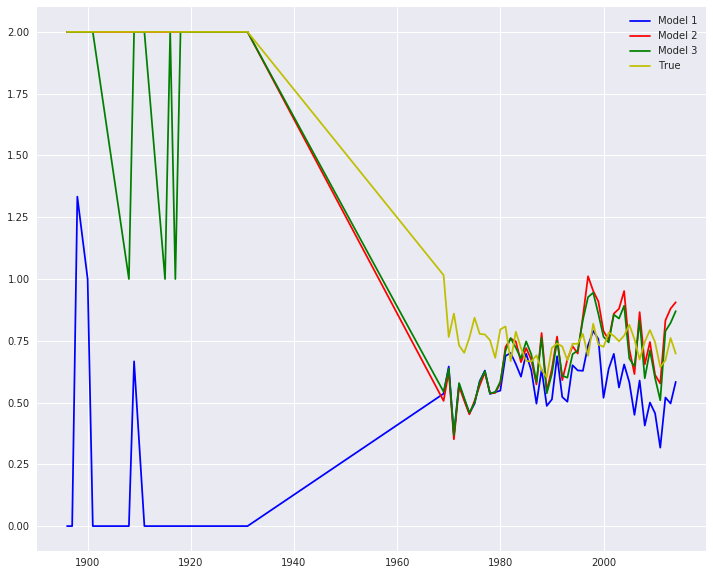

In [48]:

best_model_arch_1 = model_list[numpy.argmax(accuracies_arch_1)]
best_model_arch_2 = ml[numpy.argmax(accuracies_arch_2)]
best_model_arch_3 = ml3[numpy.argmax(accuracies_arch_3)]

preds_model_1 = best_model_arch_1.predict(X_test)
preds_model_1 = numpy.argmax(preds_model_1, axis = 1)

preds_model_2 = best_model_arch_2.predict(X_test)
preds_model_2 = numpy.argmax(preds_model_2, axis = 1)

preds_model_3 = best_model_arch_3.predict(X_test)
preds_model_3 = numpy.argmax(preds_model_3, axis = 1)

preds_model_1_df = pandas.DataFrame(preds_model_1, columns=['model_1_predictions'])
preds_model_2_df = pandas.DataFrame(preds_model_2, columns=['model_2_predictions'])
preds_model_3_df = pandas.DataFrame(preds_model_3, columns=['model_3_predictions'])

years.head(2)
years_test = years[-len(y_test) :]
years_test = years_test.reset_index()
years_test.head(2)

justice_test = raw_data[-len(y_test) :]
justice_test = justice_test.reset_index()

temp_df = pandas.concat([preds_model_1_df, preds_model_2_df], axis =1)
temp_df = pandas.concat([temp_df, preds_model_3_df], axis = 1)
temp_df = pandas.concat([temp_df, justice_test[['justice_outcome_disposition']]], axis = 1)
temp_df = pandas.concat([temp_df, years_test[['term_raw']]], axis=1)

per_year_avg_preds_model_1 = temp_df.groupby("term_raw")["model_1_predictions"].mean()
per_year_avg_preds_model_2 = temp_df.groupby("term_raw")["model_2_predictions"].mean()
per_year_avg_preds_model_3 = temp_df.groupby("term_raw")["model_3_predictions"].mean()
per_year_avg_true_model = temp_df.groupby("term_raw")["justice_outcome_disposition"].mean()

f = plt.figure(figsize=(12, 10))
plt.plot(per_year_avg_preds_model_1, color = 'b')
plt.plot(per_year_avg_preds_model_2, color = 'r')
plt.plot(per_year_avg_preds_model_3, color = 'g')
plt.plot(per_year_avg_true_model, color = 'y')
plt.legend(('Model 1', 'Model 2', 'Model 3', 'True'))



In [229]:
best_model_arch_1 = model_list[numpy.argmax(accuracies_arch_1)]
best_model_arch_2 = ml[numpy.argmax(accuracies_arch_2)]
best_model_arch_3 = ml3[numpy.argmax(accuracies_arch_3)]

preds_model_1 = best_model_arch_1.predict(X_test)
preds_model_1 = numpy.argmax(preds_model_1, axis = 1)

preds_model_2 = best_model_arch_2.predict(X_test)
preds_model_2 = numpy.argmax(preds_model_2, axis = 1)

preds_model_3 = best_model_arch_3.predict(X_test)
preds_model_3 = numpy.argmax(preds_model_3, axis = 1)

In [230]:
print(sklearn.metrics.classification_report(preds_model_1, numpy.argmax(y_test, axis =1 )))
print(sklearn.metrics.confusion_matrix(preds_model_1, numpy.argmax(y_test, axis =1 )))
print(sklearn.metrics.accuracy_score(preds_model_1, numpy.argmax(y_test, axis =1 )))

             precision    recall  f1-score   support

          0       0.90      0.76      0.83     28651
          1       0.81      0.81      0.81     13841
          2       0.54      0.87      0.67      7466

avg / total       0.82      0.79      0.80     49958

[[21912  2293  4446]
 [ 1687 11168   986]
 [  623   347  6496]]
0.792185435766


In [231]:
print(sklearn.metrics.classification_report(preds_model_2, numpy.argmax(y_test, axis =1 )))
print(sklearn.metrics.confusion_matrix(preds_model_2, numpy.argmax(y_test, axis =1 )))
print(sklearn.metrics.accuracy_score(preds_model_2, numpy.argmax(y_test, axis =1 )))

             precision    recall  f1-score   support

          0       0.89      0.83      0.86     26000
          1       0.82      0.78      0.80     14428
          2       0.69      0.86      0.76      9530

avg / total       0.83      0.82      0.82     49958

[[21518  1998  2484]
 [ 1860 11304  1264]
 [  844   506  8180]]
0.820729412707


In [232]:
print(sklearn.metrics.classification_report(preds_model_3, numpy.argmax(y_test, axis =1 )))
print(sklearn.metrics.confusion_matrix(preds_model_3, numpy.argmax(y_test, axis =1 )))
print(sklearn.metrics.accuracy_score(preds_model_3, numpy.argmax(y_test, axis =1 )))

             precision    recall  f1-score   support

          0       0.89      0.82      0.85     26217
          1       0.82      0.78      0.80     14438
          2       0.68      0.87      0.76      9303

avg / total       0.83      0.82      0.82     49958

[[21496  2064  2657]
 [ 1939 11290  1209]
 [  787   454  8062]]
0.817646823332


In [59]:
def get_the_dummy_model_accuracy_for_all_decisions():
    from sklearn.dummy import DummyClassifier
    clf = DummyClassifier(strategy='most_frequent',random_state=0)
    temp = feature_df.copy()
    temp.drop(['justice_outcome_disposition'], axis =1, inplace=True)
    
    rows = round(0.8 * len(temp))
    target_all = raw_data.loc[:,['justice_outcome_disposition']]
    
    dummy_train = temp[0:len(y_test)]
    dummy_train_target = target_all[0:len(y_test)]
    dummy_test = temp[-len(y_test):]
    dummy_test_target = numpy.argmax(y_test,axis=1)
    
    
    clf.fit(dummy_train, to_categorical(dummy_train_target))
    dummy_preds = clf.predict(dummy_test)
    dummy_preds = numpy.argmax(dummy_preds, axis = 1)
    print(sklearn.metrics.classification_report(dummy_preds, dummy_test_target))
    print(sklearn.metrics.confusion_matrix(dummy_preds, dummy_test_target))
    print(sklearn.metrics.accuracy_score(dummy_preds, dummy_test_target))

In [60]:
get_the_dummy_model_accuracy_for_all_decisions()

             precision    recall  f1-score   support

          0       1.00      0.48      0.65     49958
          1       0.00      0.00      0.00         0
          2       0.00      0.00      0.00         0

avg / total       1.00      0.48      0.65     49958

[[24222 13808 11928]
 [    0     0     0]
 [    0     0     0]]
0.484847271708


/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
